# Modello non-standard
modello che controlla la loss e traina L2 solo quando L1 è 0

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

from dataset import Dataset

In [14]:
class HingeLoss(nn.Module):
    def __init__(self,margin = 1):
        super(HingeLoss, self).__init__()
        self.margin = margin
    def forward(self, inputs, targets):
        #loss = -1 * (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        loss = torch.max(torch.tensor(0.), self.margin - inputs * targets)
        return loss.mean()

In [15]:
class NonStandard(nn.Module):
    '''
        Implementazione modello visto con Fiaschi
    '''
    def __init__(self, input_size, output_size, hidden_size, margin = 1):
        super(NonStandard, self).__init__()
        self.ort_base = None

        self.loss = HingeLoss(margin)
        
        self.W1 = torch.nn.Linear(input_size, hidden_size)
        self.W2 = torch.nn.Linear(hidden_size, output_size)

        self.ReLU = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()

        self.optimizer = torch.optim.SGD(self.parameters(), lr = 1e-4)
    
# --------------------------------------------

    def forward(self, x):
        k = self.W1(x)
        z = self.ReLU(k)
        y = self.W2(z)
        
        return y

    def train(self, dl):
        for x,y in dl:
            self.optimizer.zero_grad()

            # Devo trainare per L1 e per L2
            # Gradiente rispetto a L1 lo applico, rispetto a L2 lo memorizzo
            
            y_pred_1 = self(x[y == 1])
            y_target_1 = y.unsqueeze(1)[y.unsqueeze(1) == 1]

            y_pred_2 = self(x[y == -1])
            y_target_2 = y.unsqueeze(1)[y.unsqueeze(1) == -1]

            eL1 = self.loss(y_pred_1, y_target_1)
            eL1.backward(retain_graph = True)

            eL2 = self.loss(y_pred_2, y_target_2)

            if (eL1 == 0).all():
                eL2.backward()
                
            self.optimizer.step()

        return eL1.detach().numpy(), eL2.detach().numpy()

In [16]:
dataset = Dataset(8, True)
dl = dataset.get_dataloader()
dl1, dl0 = dataset.get_separated_dataloaders()

In [17]:
modello = NonStandard(2, 1, 120, 2)

err = []
for _ in tqdm(range(200)):
    e = modello.train(dl)
    err.append(e)


100%|██████████| 200/200 [00:01<00:00, 114.63it/s]


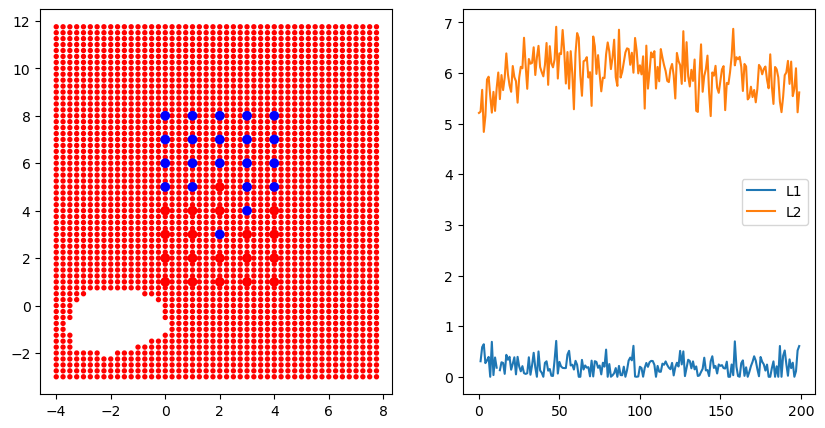

In [18]:
fig, plot = plt.subplots(1, 2, figsize=(10, 5))
with torch.no_grad():
    points = [[x/4, y/4, modello(torch.tensor([x/4*1.0,y/4*1.0]))] for x in range(-4*4,8*4) for y in range(-3*4,12*4)]

colori = ['red' if p[2][0] > 0.5 else 'blue' if p[2][0] < -0.5 else 'white' for p in points]

plot[0].scatter([p[0] for p in points], [p[1] for p in points], c = colori, s=8)
plot[0].scatter([p[0] for p in dataset.dataset],[p[1] for p in dataset.dataset], c=['red' if i == 1 else 'blue' for i in dataset.labels])
plot[1].plot([x for x in range(len(err))], err, label=['L1', 'L2'])
plt.legend()
plt.show()